In [1]:
import autograd.numpy as np
from autograd import grad as auto_grad, jacobian as auto_jacobian
import scipy

import matplotlib.pyplot as plt
import seaborn

In [3]:
def solve_square_with_qr(A, b):
    """Solve system of equations with square (real values) matrix A: A * x = b"""""
    Q, R = np.linalg.qr(A)
    x = scipy.linalg.solve_triangular(R, Q.T @ b)
    return x


def solve_symm_with_chol(A, b):
    """Solve system of equations with symmetric (hermitian) matrix A: A * x = b"""""
    c, lower = scipy.linalg.cho_factor(A)
    x = scipy.linalg.cho_solve((c, lower), b)
    return x

In [9]:
n0 = 1
def objective_fn0(x):
    y = - x[..., 0]**2
    return y

def constraint_fn0(x):
    c0 = x[..., 0] - 1
    return np.array([c0])

grad_fn0 = auto_grad(objective_fn0)
hessian_fn0 = auto_jacobian(grad_fn0)
jacobian_cnst0 = auto_jacobian(constraint_fn0)

n1 = 2
def objective_fn1(x):
    y = x[..., 0]**2 + x[..., 1]**2
    return y

def constraint_fn1(x):
#     c0 = x[..., 0]**2 + x[..., 1]**2 - 1
#     return np.array([c0])
#     c0 = x[..., 0]**2 - x[..., 1] - 1
#     return np.array([c0])
    c0 = 3*x[..., 0] - x[..., 1] - 1
    return np.array([c0])

grad_fn1 = auto_grad(objective_fn1)
hessian_fn1 = auto_jacobian(grad_fn1)
jacobian_cnst1 = auto_jacobian(constraint_fn1)

In [77]:
def min_newton_method_eq_constraint_feasible(objective_fn, grad_fn, hessian_fn, constraint_fn, jacobian_cnst_fn, x0,
                                             alpha_min=1e-6, alpha_max=1e6,
                                             obj_tol=1e-15, cnst_tol=1e-15, max_iterations=10**6):
    """Minimize non-linear function with linear equality constraints.
    The initial point 'x0' has to be feasible."""

    assert np.abs(constraint_fn(x0)) < cnst_tol, \
        "The initial point has to be feasible ({} is above tolerance {})".format(
            np.abs(constraint_fn(x0)), cnst_tol)

    num_vars = x0.shape[0]
    num_cnst = constraint_fn(x0).shape[0]
    if x0.ndim == 1:
        x0 = x0[:, np.newaxis]

    x = np.array(x0)
    iteration = 0
    dobj = float("inf")
    obj_value = objective_fn(x[:, 0])
    while np.abs(dobj) > obj_tol and iteration < max_iterations:
        prev_obj_value = obj_value
        grad = grad_fn(x[:, 0])[:, np.newaxis]
        jacobian_cnst = jacobian_cnst_fn(x[:, 0])
        constraint = constraint_fn(x[:, 0])[:, np.newaxis]
        hessian = hessian_fn(x[:, 0])
        # Hessian modification
#         eigvals = np.linalg.eigvalsh(hessian)
#         if eigvals[0] <= 0:
#             hessian += (1 + np.abs(eigvals[0])) * np.eye(hessian.shape[0])

        # Generate newton system
        A_upper = np.block([[hessian, jacobian_cnst.T]])
        A_lower = np.block([[jacobian_cnst, np.zeros((num_cnst, num_cnst))]])
        A = np.concatenate((A_upper, A_lower), axis=0)
        b = np.concatenate((-grad, np.zeros((num_cnst, 1))), axis=0)
        # Solve for step direction.
        # This is usually the main computational burden so should be
        # an efficient method depending on structure of A.
        y = np.linalg.solve(A, b)
        step_dir = y[:num_vars, :]
        # Lagrange variables
        nu = y[num_vars:, :]

        # Backtracking line-search
        alpha = alpha_max
        x_next = x
        dobj = float("inf")
        while dobj >= 0 and alpha >= alpha_min:
            step = alpha * step_dir
            x_next = x + step
            obj_value = objective_fn(x_next[:, 0])
            dobj = obj_value - prev_obj_value
            alpha *= 0.5
        iteration += 1

        if dobj >= 0:
            break
        x = x_next

    obj_value = objective_fn(x[:, 0])
    constraint_value = constraint_fn(x[:, 0])
    info = {
        "obj_value": obj_value,
        "constraint_value": constraint_value,
        "iteration": iteration,
        "max_iterations": max_iterations,
        "nu": nu,
    }
    x = x[:, 0]
    return x, info

In [83]:
def min_newton_method_eq_constraint(objective_fn, grad_fn, hessian_fn,
                                    constraint_fn, jacobian_cnst_fn,
                                    x0, nu0=None,
                                    eps=1e-15, r_tol=1e-15, cnst_tol=1e-15, max_iterations=10**6):
    num_vars = x0.shape[0]
    num_cnst = constraint_fn(x0).shape[0]
    if nu0 is None:
        nu0 = np.zeros((num_cnst, 1))
    alpha = 0.25
    beta = 0.5
    if x0.ndim == 1:
        x0 = x0[:, np.newaxis]
    if nu0.ndim == 1:
        nu0 = nu0[:, np.newaxis]

    x = np.array(x0)
    nu = np.array(nu0)
    iteration = 0
    while iteration < max_iterations:
        grad = grad_fn(x[:, 0])[:, np.newaxis]
        jacobian_cnst = jacobian_cnst_fn(x[:, 0])
        constraint = constraint_fn(x[:, 0])[:, np.newaxis]
        hessian = hessian_fn(x[:, 0])
        # Hessian modification
#         eigvals = np.linalg.eigvalsh(hessian)
#         if eigvals[0] <= 0:
#             hessian += (1 + np.abs(eigvals[0])) * np.eye(hessian.shape[0])

        # Generate newton system
        A_upper = np.block([[hessian, jacobian_cnst.T]])
        A_lower = np.block([[jacobian_cnst, np.zeros((num_cnst, num_cnst))]])
        A = np.concatenate((A_upper, A_lower), axis=0)
        b = np.concatenate((-grad + jacobian_cnst.T @ nu, -constraint), axis=0)
        # Solve for step direction.
        # This is usually the main computational burden so should be
        # an efficient method depending on structure of A.
        dy = np.linalg.solve(A, b)
        dx = dy[:num_vars, :]
        dnu = dy[num_vars:, :]
        print("dx:", dx, ", dnu:", dnu)

        r = lambda x, nu: np.concatenate((grad_fn(x[:, 0])[:, np.newaxis] + jacobian_cnst_fn(x[:, 0]).T @ nu, constraint_fn(x[:, 0])[:, np.newaxis]), axis=0)

        # Line search on newton decrement
        t = 1.
        r_value1 = r(x, nu)
        r_norm1 = np.linalg.norm(r_value1)
        while True:
            r_value2 = r(x + t * dx, nu + t * dnu)
            r_norm2 = np.linalg.norm(r_value2)
            if r_norm2 <= (1 - alpha * t) * r_norm1:
                break
            t *= beta
        x += t * dx
        nu += t * dnu
        iteration += 1

        if r_norm2 <= r_tol and np.abs(constraint_fn(x[:, 0])) <= cnst_tol:
            break
        if np.linalg.norm(t * dx) <= eps and np.linalg.norm(t * dy) <= eps:
            break


    obj_value = objective_fn(x[:, 0])
    constraint_value = constraint_fn(x[:, 0])
    info = {
        "obj_value": obj_value,
        "constraint_value": constraint_value,
        "r_value": r_value2,
        "iteration": iteration,
        "max_iterations": max_iterations,
        "t": t,
        "nu": nu[:, 0],
    }
    x = x[:, 0]
    return x, info

dx: [[-4.]] , dnu: [[2.]]
minimum x: [1.]
objective value: -1.0
constraint value: [0.]
iteration: 1


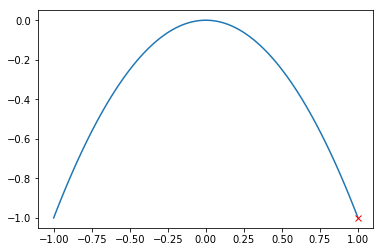

In [91]:
# Minimize function #0 with newton method
x0 = np.array([5.])
max_iterations = 10
x_min, info = min_newton_method_eq_constraint(objective_fn0, grad_fn0, hessian_fn0, constraint_fn0, jacobian_cnst0, x0,
                                              max_iterations=max_iterations)
print("minimum x: {}".format(x_min))
print("objective value: {}".format(info["obj_value"]))
print("constraint value: {}".format(info["constraint_value"]))
# print("r_value: {}".format(info["r_value"]))
print("iteration: {}".format(info["iteration"]))

# Plot function and found minimum
plt.figure()
x = np.linspace(-np.abs(x_min), +np.abs(x_min), 100)[:, np.newaxis]
plt.plot(x, objective_fn0(x))
plt.plot([x_min], [objective_fn0(x_min)], 'rx')
plt.show()

[-4995.]
minimum x: [ 0.3 -0.1]
objective value: 0.10000000000000005
constraint value: [2.22044605e-16]
iteration: 2


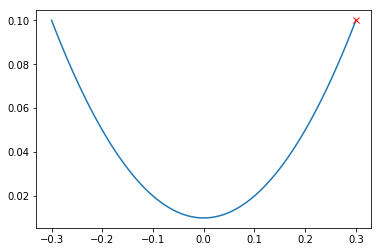

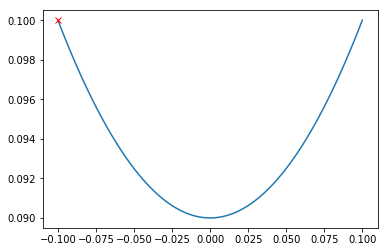

In [75]:
# Minimize function #1 with newton method
x0 = np.array([2., 5.])
x0 = np.array([2., 5000.])
# x0 = np.array([2., 0.])
print(constraint_fn1(x0))
max_iterations = 10
x_min, info = min_newton_method_eq_constraint(objective_fn1, grad_fn1, hessian_fn1, constraint_fn1, jacobian_cnst1, x0,
                                   max_iterations=max_iterations)
print("minimum x: {}".format(x_min))
print("objective value: {}".format(info["obj_value"]))
print("constraint value: {}".format(info["constraint_value"]))
# print("r_value: {}".format(info["r_value"]))
print("iteration: {}".format(info["iteration"]))

# Plot function and found minimum
plt.figure()
x = np.linspace(-np.abs(x_min[0]), +np.abs(x_min[0]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn1(np.array([v, x_min[1]])) for v in x])
plt.plot([x_min[0]], [objective_fn1(x_min)], 'rx')
plt.show()

plt.figure()
x = np.linspace(-np.abs(x_min[1]), +np.abs(x_min[1]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn1(np.array([x_min[0], v])) for v in x])
plt.plot([x_min[1]], [objective_fn1(x_min)], 'rx')
plt.show()

minimum x: [ 0.30010183 -0.09969452]
objective value: 0.10000010368971377
constraint value: [-1.66533454e-15]
iteration: 100


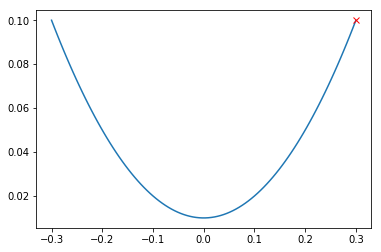

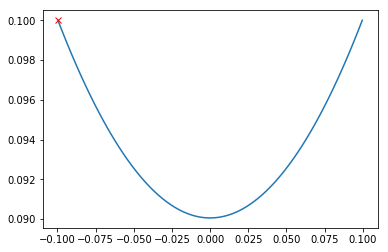

In [40]:
# Minimize function #1 with newton method starting from feasible point
x0 = np.array([2., 5.])
max_iterations = 100
x_min, info = min_newton_method_eq_constraint_feasible(objective_fn1, grad_fn1, hessian_fn1, constraint_fn1, jacobian_cnst1, x0,
                                   max_iterations=max_iterations)
print("minimum x: {}".format(x_min))
print("objective value: {}".format(info["obj_value"]))
print("constraint value: {}".format(info["constraint_value"]))
print("iteration: {}".format(info["iteration"]))

# Plot function and found minimum
plt.figure()
x = np.linspace(-np.abs(x_min[0]), +np.abs(x_min[0]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn1(np.array([v, x_min[1]])) for v in x])
plt.plot([x_min[0]], [objective_fn1(x_min)], 'rx')
plt.show()

plt.figure()
x = np.linspace(-np.abs(x_min[1]), +np.abs(x_min[1]), 100)[:, np.newaxis]
plt.plot(x, [objective_fn1(np.array([x_min[0], v])) for v in x])
plt.plot([x_min[1]], [objective_fn1(x_min)], 'rx')
plt.show()